In [2]:
import subprocess as sp
from pymongo import MongoClient
import json
import pandas as pd
from collections import Counter # counter object for ingredient-counts
import re # used to obtain Wikidata URIs
from py2neo import Graph # to interact with Neo4j
from graphdatascience import GraphDataScience # to create embeddings

import seaborn as sns
sns.set_style('whitegrid')
from matplotlib import pyplot as plt
from nltk.stem import WordNetLemmatizer # for lemmatization
import nltk # extract nouns

# get working directory
data = '../data'
prod_dir = data+'/raw/products.json'

# MongoDB

Open Food Facts provides a MongoDB dump of their entire database of products. This is used instead of the CSV as it contains more information about the products. In order to read this dump, MongoDB  and its database tools is required. The dump file is available on [Open Food Facts](https://world.openfoodfacts.org/data).

## Import dump into a local instance

In order to access the MongoDB dump, it has to be restored locally.

In [8]:
try:
    sp.check_output(
        f'mongorestore {data}/raw/dump/', shell=True
        )
    
except sp.CalledProcessError as e:
    print(e.output)

2023-02-27T02:25:04.980+0100	preparing collections to restore from
2023-02-27T02:25:04.981+0100	reading metadata for off.products from /Users/jnb/thesis/frs/code/data/raw/dump/off/products.metadata.json
2023-02-27T02:25:05.081+0100	restoring off.products from /Users/jnb/thesis/frs/code/data/raw/dump/off/products.bson
2023-02-27T02:25:07.982+0100	[########################]  off.products  28.0MB/44B  (66697345.5%)
2023-02-27T02:25:10.980+0100	[########################]  off.products  186MB/44B  (443673350.0%)
2023-02-27T02:25:13.980+0100	[########################]  off.products  373MB/44B  (890075970.5%)
2023-02-27T02:25:16.980+0100	[########################]  off.products  587MB/44B  (1398550079.5%)
2023-02-27T02:25:19.980+0100	[########################]  off.products  774MB/44B  (1844568688.6%)
2023-02-27T02:25:22.980+0100	[########################]  off.products  943MB/44B  (2247282204.5%)
2023-02-27T02:25:25.980+0100	[########################]  off.products  1.08GB/44B  (2647650965.9

## Export products with ingredients

Get all products with product name and ingredients.

In [9]:
# connect to MongoDB
db = MongoClient().off

In [10]:
# count number of products
count = db.products.estimated_document_count()
print(f'Number of products in database: {count}')

Number of products in database: 2708305


In [11]:
# example of what a product looks like
db.products.find_one({'ingredients': { '$exists': 'true', '$ne': ''}, 
     'product_name': { '$exists': 'true', '$ne': ''}}, 
     {'ingredients': 1, 'product_name': 1})

{'_id': '0000000000000',
 'ingredients': [{'percent_max': 100,
   'percent_min': 20,
   'text': "MODE D'UTILISATION utilisez la ut assaisonner les potes 'les pizzas et lasagnes",
   'id': 'en:mode-d-utilisation-utilisez-la-ut-assaisonner-les-potes-les-pizzas-et-lasagnes',
   'percent_estimate': 60.0},
  {'ingredients': [{'percent_estimate': 20.0,
     'id': 'en:pourioogde-produit-dtmurts-leg-prunes-lg-0-3b-4-22-cascina-san-cassiano-c-so-piave',
     'text': 'POURIOOgDE PRODUIT dtmùrts lég Prunes lg 0‚3B 4‚22 Cascina San Cassiano C.so Piave',
     'percent_min': 0,
     'percent_max': 50}],
   'percent_max': 50,
   'text': "Prête o l'emploi",
   'percent_min': 0,
   'id': 'en:prete-o-l-emploi',
   'percent_estimate': 20},
  {'percent_estimate': 10.0,
   'id': 'en:182',
   'percent_min': 0,
   'text': '182',
   'percent_max': 33.333333333333336},
  {'origins': 'en:china',
   'percent_min': 0,
   'text': 'Alba',
   'percent_max': 25,
   'percent_estimate': 5.0,
   'id': 'en:alba'},
  {'pe

In [12]:
# create subset of products with name and ingredients
result = db.products.aggregate([
    {'$match': 
     {'ingredients': {'$exists': 'true', '$ne': ''},
      'product_name': {'$exists': 'true', '$ne': ''}}
      },
      {'$project':
       {'product_name': 1, 'ingredients': 1}},
      {'$out': 'subset'}
])

In [13]:
# count of products with a name and ingredients
count = db.subset.estimated_document_count()
print(f'Number of products in subset: {count}')

Number of products in subset: 793860


In [14]:
# export subset to json for further processing
try:
    sp.check_output(
        f'mongoexport --collection=subset --db=off -f "_id,product_name,ingredients" --out={data}/raw/products.json', shell=True
        )
    
except sp.CalledProcessError as e:
    print(e.output)

2023-02-27T03:12:53.491+0100	connected to: mongodb://localhost/
2023-02-27T03:12:54.494+0100	[........................]  off.subset  0/793860  (0.0%)
2023-02-27T03:12:55.492+0100	[........................]  off.subset  8000/793860  (1.0%)
2023-02-27T03:12:56.492+0100	[........................]  off.subset  8000/793860  (1.0%)
2023-02-27T03:12:57.495+0100	[........................]  off.subset  16000/793860  (2.0%)
2023-02-27T03:12:58.492+0100	[........................]  off.subset  24000/793860  (3.0%)
2023-02-27T03:12:59.492+0100	[........................]  off.subset  32000/793860  (4.0%)
2023-02-27T03:13:00.492+0100	[#.......................]  off.subset  40000/793860  (5.0%)
2023-02-27T03:13:01.492+0100	[#.......................]  off.subset  48000/793860  (6.0%)
2023-02-27T03:13:02.492+0100	[#.......................]  off.subset  64000/793860  (8.1%)
2023-02-27T03:13:03.492+0100	[##......................]  off.subset  72000/793860  (9.1%)
2023-02-27T03:13:04.492+0100	[##..........

While some products contain ingredients that exists, there are also products with ingredient fields not containing ingredients.

# Raw data exploration

In [ ]:
# create a dataframe consisting of product name, barcode, ingredients and amount
with open(f'{data}/raw/products.json') as infile:
    rows = list()
    for product in infile:
        row = dict()
        # get information on product
        product = json.loads(product)
        row['barcode'] = product['_id']
        row['product name'] = product['product_name']

        # get information on ingredient
        for ingredient in product['ingredients']:
            if float(ingredient.get('percent_estimate', 0)) > 0:
                row['ingredient'] = ingredient['id']
                row['amount'] = float(ingredient['percent_estimate'])
                rows.append(row.copy())
    df = pd.DataFrame.from_dict(rows)
    df.to_pickle(f'{data}/dataframes/raw.pkl') 

In [5]:
df = pd.read_pickle(f'{data}/dataframes/raw.pkl')

In [6]:
print('Number of unique product barcodes:', len(df['barcode'].unique()))

Number of unique product barcodes: 791851


## Ingredient occurrence

In [7]:
# get ingredients and counts
ingredients = df['ingredient'].value_counts().sort_values(ascending=False)
ingredients = ingredients.rename_axis('ingredient').reset_index(name='count')
print('Number of unique ingredients:', len(ingredients))
print('Number of ingredients used once:', len(ingredients[ingredients['count'] == 1]))

Number of unique ingredients: 678452
Number of ingredients used once: 567807


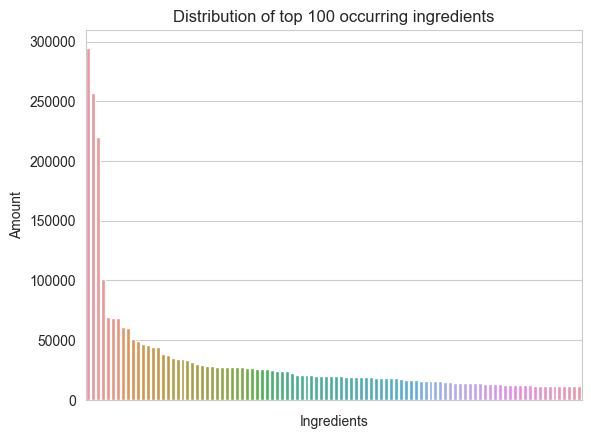

In [264]:
# plot distribution of top 100 ingredients
g = sns.barplot(x='ingredient', y='count', data=ingredients[:100])
_ = g.set_title('Distribution of top 100 occurring ingredients')
_ = g.set_xticklabels([])
_ = g.set_xlabel('Ingredients')
_ = g.set_ylabel('Amount')

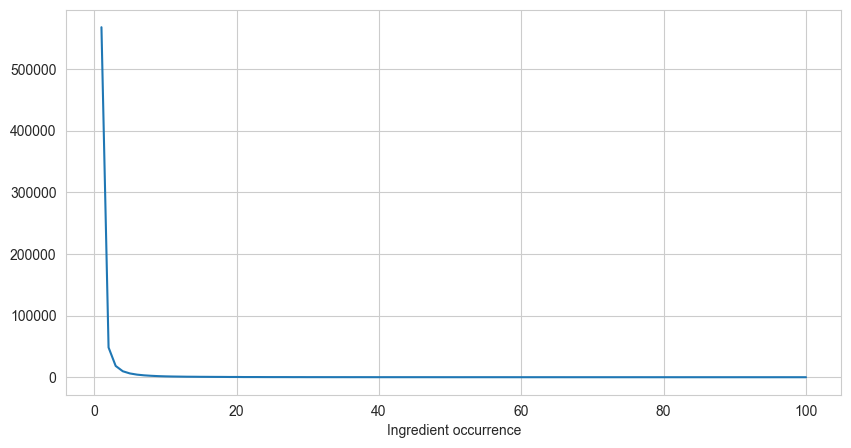

In [126]:
# get distribution of occurrences
dist = ingredients['count'].value_counts().sort_index()[:100]
plt.figure(figsize=(10,5))
g = sns.lineplot(x=dist.index, y=dist.values)
_ = g.set_xlabel('Ingredient occurrence')
plt.savefig(data+'/results/preprocessing/ingocc.png', dpi=300)

In [222]:
# show the most frequent ingredients
ingredients.head(20)

,ingredient,count
0,en:salt,294809
1,en:sugar,256770
2,en:water,220133
3,en:natural-flavouring,101384
4,en:wheat-flour,69213
5,en:spice,68822
6,en:e330,68688
7,en:onion,61134
8,en:flavouring,60412
9,en:colour,51075


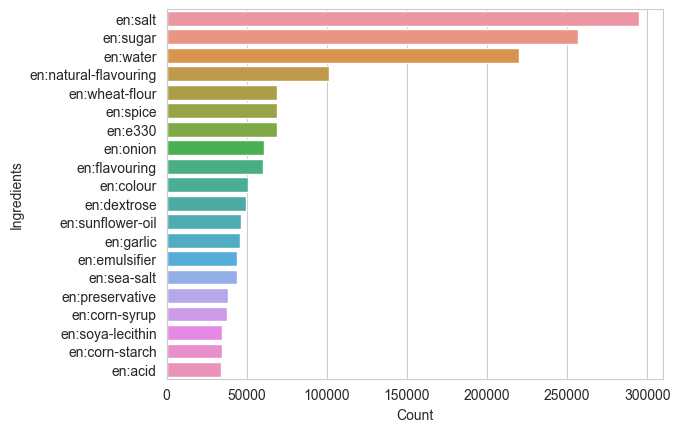

In [128]:
# plot distribution of top 20 ingredients
g = sns.barplot(x='count', y='ingredient', data=ingredients.head(20))
_ = g.set_ylabel('Ingredients')
_ = g.set_xlabel('Count')
plt.savefig(f'{data}/results/preprocessing/top20ings.png', dpi=300, bbox_inches='tight')

In [224]:
# show least frequent ingredients
ingredients['ingredient'].tail(50)

678402                                 fr:polyquaternium-52
678403                                     fr:quaternium-80
678404                                        fr:laureth-16
678405                      fr:stearoxypropyl-dimethylamine
678406                                            fr:totaal
678407    fr:gecontroleerd-en-afkomstig-van-fairtrade-pr...
678408                                        fr:verhandeld
678409          fr:pindakaas-met-stukjes-pinda-ingredienten
678410                                     pl:ser twarogowy
678411                                  en:su and sulphites
678412                                  de:Kräuter Mischung
678413                    cs:Rehydratovaná sójová bílkovina
678414                        en:Glazing Agent E Sabilizers
678415                      en:SYNTHETIC FOOD ADDED FLAVOUR
678416                          en:Emulsifier E Stabilizers
678417                                          ca:calabaza
678418                                  

In [13]:
# get languages
ingredients['lang'] = ingredients['ingredient'].apply(lambda s: s.split(':')[0])

# get proportion of english ingredients
for occurrence in list(range(1,10)):
    selection = ingredients[ingredients['count'] > occurrence]
    english = selection[selection['lang'] == 'en']
    print('Threshold:', occurrence)
    print('Proportion of English ingredients:', len(english)/len(selection))

Threshold: 1
Proportion of English ingredients: 0.4587645171494419
Threshold: 2
Proportion of English ingredients: 0.5022439493508575
Threshold: 3
Proportion of English ingredients: 0.5323092979988202
Threshold: 4
Proportion of English ingredients: 0.5556880653887548
Threshold: 5
Proportion of English ingredients: 0.5755515421934204
Threshold: 6
Proportion of English ingredients: 0.5933155747939732
Threshold: 7
Proportion of English ingredients: 0.6075671549215135
Threshold: 8
Proportion of English ingredients: 0.6201105328110748
Threshold: 9
Proportion of English ingredients: 0.6314416177429876


In [19]:
# look at ingredients occurring six times
print(ingredients[ingredients['count'] == 6].to_string())

                                                                                                   ingredient  count lang
24026                                                                                           en:energy fat      6   en
24027                                                                                     fr:sirop-de-qlucose      6   fr
24028                                                                           fr:vanille-en-gousses-bourbon      6   fr
24029                                                                                          en:peanut-meal      6   en
24030                                                                                     es:almendra-marcona      6   es
24031                                                                             de:beeren-gefriergetrocknet      6   de
24032                                                                                     en:chihuahua-cheese      6   en
24033                   

Most of the ingredients in this dataset are only used once. Ingredients with a low occurrence are less likely to be valid. This is shown above with the most and least used ingredients. Based on manual assessment of the ingredients, valid ingredients are found with a count of 6 or more. A threshold of 6 will therefore increase the precision of valid ingredients. However, there are still a few nonsensical ingredients. It can be useful to extract the nouns of these ingredients, in order to make them valid and increase the recall.

## Language tags

In [130]:
languages = ingredients['ingredient'].str.split(':').str[0].value_counts()
languages = languages.rename_axis('language').reset_index(name='count')
print('Number of unique languages:', len(languages['language']))

Number of unique languages: 82


In [135]:
languages.tail(10)

,language,count
72,ug,1
73,mn,1
74,pt-pt-carne-de-porco,1
75,ee,1
76,ga,1
77,lb,1
78,pt-pt-categoria-ii,1
79,pt-pt-calibre-22,1
80,pt-pt-35,1
81,pt-pt-cenouras-da-variedade-nantes,1


In [132]:
# replace common language tags
expand_tag = {
    'en': 'English',
    'fr': 'French',
    'de': 'German',
    'es': 'Spanish',
    'it': 'Italian',
    'pt': 'Portugese',
    'th': 'Thai',
    'ro': 'Romanian',
    'ru': 'Russian',
    'nl': 'Dutch',
}
languages = languages.replace({'language': expand_tag})

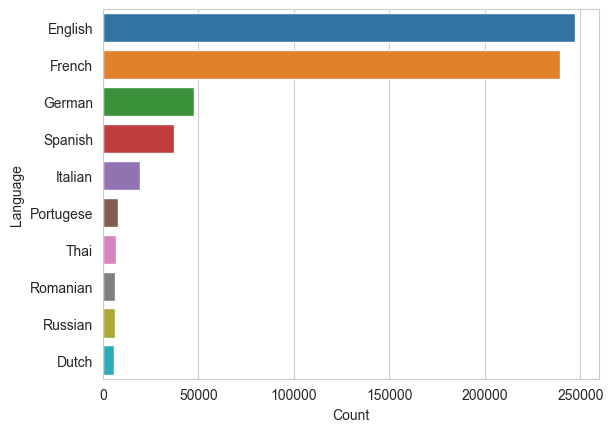

In [133]:
g = sns.barplot(x='count', y='language', data=languages.head(10))
_ = g.set_xlabel('Count')
_ = g.set_ylabel('Language')
plt.savefig(f'{data}/results/preprocessing/langs.png', dpi=300)

English is the most used language for the ingredients.

## Ingredients per product

In [266]:
# number of ingredients per product
products = df['barcode'].value_counts()
products.describe()

count    791851.000000
mean          8.768445
std           7.380838
min           1.000000
25%           3.000000
50%           7.000000
75%          12.000000
max         139.000000
Name: barcode, dtype: float64

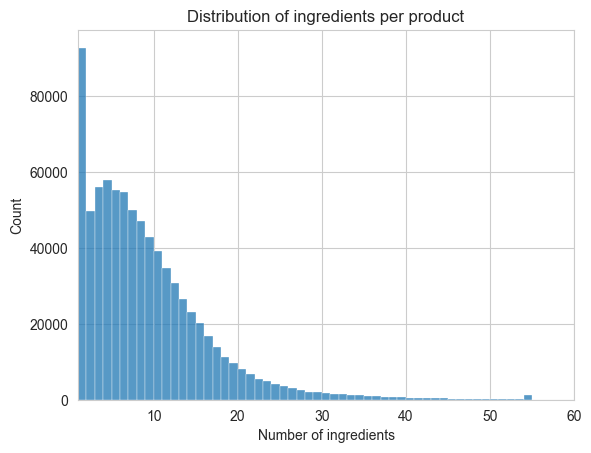

In [279]:
g = sns.histplot(products, binwidth=1)
_ = g.set_title('Distribution of ingredients per product')
_ = g.set_xlabel('Number of ingredients')
_ = g.set_xlim(1,60)
plt.savefig(f'{data}/results/preprocessing/ingperprod.png', dpi=300)

This plot shows that most of the products contain one ingredient. This is not valuable downstream as no co-occurrence can be found, and can be removed from the dataset. Most products contain four ingredients. The distribution has a long right handed tail.

# Parse products

In order to create nodes and relationships in Neo4j, preprocessing is a necessary step. Furthermore, the ingredients must be cleaned as the Open Food Facts data is very noisy.

### Ingredient counts

The counts of every ingredient is used as a filtering step before cleaning the data. A threshold of n is used to remove the ingredients.

In [113]:
""" # count ingredients
with open(f'{data}/raw/products.json') as infile:
    counts = Counter() # object for counting
    for line in infile: # iterate through products
        product = json.loads(line.lower()) 
        for ingredient in product['ingredients']: # iterate through ingredients
            counts.update([ingredient['id']]) # update count of ID """

In [ ]:
""" # write counts to csv
with open(f'{data}/ingredient_counts.csv', 'w') as outfile:
    for id, count in counts.items():
        outfile.write(f'{id},{count}\n') """

In [2]:
counts = {}
with open(f'{data}/ingredient_counts.csv') as infile:
    for line in infile:
        id, count = line.rsplit(',', 1)
        counts[id] = int(count)

In [ ]:
# assess occurrence threshold
counts_df = pd.Series(counts).rename_axis('ingredient').reset_index(name='count')
counts_df['lang'] = counts_df['ingredient'].apply(lambda s: s.split(':')[0])

# get proportion of english ingredients
for occurrence in list(range(1,10)):
    selection = counts_df[counts_df['count'] > occurrence]
    english = selection[selection['lang'] == 'en']
    print('Threshold:', occurrence)
    print('Proportion of English ingredients:', len(english)/len(selection))

In [9]:
# filter out ingredients based on occurrence and language
ingredients_keep = {
    ing for ing, count in counts.items() if count  >= 5 and ing.startswith('en:')}

### Wikidata URIs

A [file](https://world.openfoodfacts.org/ingredients.json) provided by Open Food Facts is used to obtain Wikidata URIs for the ingredients. This will be used later for enriching the graph.

In [10]:
with open(f'{data}/raw/ingredients.json') as infile:
    wiki = dict() # dictionary to store all ingredients with wikidata URI
    for line in infile:
        line = json.loads(line.lower())
        for ingredient in line['tags']:
            uri = re.search(r"q\d+", ingredient.get('sameas', [''])[0])
            if uri:
                ingredient_id = ingredient['id'].split(':', 1)[-1]
                wiki[ingredient_id] = uri.group().upper()

### Cleaning ingredients

Clean ingredients are obtained by matching them to the Wikidata URIs. The ingredients that are not matched go through additional cleaning steps. Only english ingredients are kept, stopwords are removed, the ingredients containing 'and' are splitted and the nouns are extracted. This is done in order to match the Open Food Facts ID field on Wikidata.

In [11]:
# helper function to print progress
def count_lines(path):
    """Count number of lines in a file."""
    with open(path) as infile:
        return sum(1 for line in infile)

In [3]:
# function to split ingredients, extract and lemmatize nouns from ingredients
def extract_nouns(string):
    """Extracts lemmatized nouns from a string."""
    lemmatizer = WordNetLemmatizer() # for lemmatization of nouns
    clean = list() # to store cleaned ingredients
    stopwords = {
        'lowfat', 'contains', 's', 'minute', 'invert', 'in'
    }
    # split on 'and'
    for ingredient in string.split(' and '):
        # tokenize string
        tokens = nltk.word_tokenize(ingredient)
        # remove stopwords (add all english stopwords here)
        tokens = [token for token in tokens if not token in stopwords]
        tags = nltk.pos_tag(tokens) # tag word classes
        nouns = [
            lemmatizer.lemmatize(word) for word, wclass in tags if wclass.startswith('NN') and word not in stopwords
        ]
        clean.append('-'.join(nouns))
    return clean

In [26]:
with open(prod_dir) as infile:
    # count number of lines to keep track of progress
    total = count_lines(prod_dir)
    # initialize variables to store products, ingredients, recipes and relationships.
    products, ingredients, recipes, relationships = {}, {}, {}, set()

    # iterate through JSON-objects
    for i, line in enumerate(infile, 1):
        print(f'{i}/{total}', end='\r')
        product = json.loads(line.lower())
        # remove non alphabetical characters, keep whitespace
        product_name = re.sub(r'[^a-z\s]', '', product['product_name'])
        # remove leading or trailing whitespace
        product_name = re.sub(r'^\s+|\s+$', '', product_name)
        # replace newline characters with space
        product_name = re.sub(r'\n', ' ', product_name)
        product_id = str(product['_id'])
        # skip parsing if product id is empty or already parsed
        if not product_id or products.get(product_id):
            continue
        # add product to dictionary
        products[product_id] = product_name
        
        # iterate through ingredients of one product
        for ingredient in product['ingredients']:
            # if ingredient is above occurrence threshold and english
            if ingredient['id'] in ingredients_keep:
                # remove language tag
                ingredient_id = [ingredient['id'].split(':', 1)[-1]]
                # clean ingredients without corresponding URI
                if not wiki.get(ingredient_id[0]):
                    # remove letters and symbols
                    ingredient_id = re.sub(r'[^a-z\-]', '', ingredient_id[0])
                    # replace dash with space
                    ingredient_id = ingredient_id.replace('-', ' ')
                    # extract nouns
                    ingredient_id = extract_nouns(ingredient_id)
                # add ingredient(s) to dictionary
                for id in ingredient_id:
                    if len(id) > 1: 
                        ingredients[id] = wiki.get(id, '')

                        # write relationship per ingredient
                        amount = float(ingredient.get('percent_estimate', 0))
                        if amount > 0:
                            relationships.add(
                                (product['_id'], id, amount)
                                )
                            if recipes.get(product_id):
                                recipes[product_id] += ',' + id
                            else:
                                recipes[product_id] = id

### Write CSV-files

Three CSV-files are written. One file contains the barcodes and corresponding product names. Another file contains ingredients and URIs. The last file contains product barcodes, ingredients and ingredient amounts in the product. With these files, it will be possible to create a graph in Neo4j.

In [29]:
# set output directory
outdir = f'{data}/subset'

In [34]:
# write barcodes and product names
with open(outdir+'/products.csv', 'w') as outfile:
    outfile.write('id,name\n')
    for id, name in products.items():
        outfile.write(f'{id},"{name}"\n')

In [ ]:
# write ingredient names and URIs
with open(outdir+'/ingredients.csv', 'w') as outfile:
    outfile.write('name,uri\n')
    for id, uri in ingredients.items():
        outfile.write(f'{id},"{uri}"\n')

In [ ]:
# write product barcodes, ingredient names and amount
with open(outdir+'/relationships.csv', 'w') as outfile:
    outfile.write('product_id,ingredient_id,amount\n')
    for product_id, ingredient_id, amount in relationships:
        outfile.write(f'{product_id},"{ingredient_id}",{amount}\n')

In [36]:
# write product barcodes and all ingredients
with open(outdir+'/recipes.csv', 'w') as outfile:
    outfile.write('product_id,ingredients\n')
    for product_id, ingredients in recipes.items():
        # write products with more than one ingredient
        # TODO Should this be handled in parsing?
        # TODO  Add to preprocess script and create file for all data
        if len(ingredients.split(',')) > 1:
            outfile.write(f'{product_id},"{ingredients}"\n')

# Handle Neo4j

A local database management system is created with Neo4j Desktop. The APOC and Neosemantics plugins are installed. The CSV-files are linked to the import folder. dbms.unmanaged_extension_classes=n10s.endpoint=/rdf is added as a line to the configuration file (neo4j.conf). This is important for the enrichment steps later.

In [3]:
# connect to the graph instance
url = 'neo4j://localhost:7687'
user, password = 'neo4j', 'admin'
g = Graph(url, auth=(user, password))
g.run('RETURN "connected"')

"""connected"""
connected


## Create nodes

In [4]:
# create indices for ingredient, product and resource properties
query = r"""
CALL apoc.schema.assert({},{Ingredient:['og_name'], Product:['barcode'], Resource:['uri']})
"""
result = g.run(query)
print(result)

 label      | key     | keys        | unique | action  
------------|---------|-------------|--------|---------
 Resource   | uri     | ['uri']     | true   | CREATED 
 Ingredient | og_name | ['og_name'] | true   | CREATED 
 Product    | barcode | ['barcode'] | true   | CREATED 



In [5]:
# create ingredient nodes
query = r"""
LOAD CSV WITH HEADERS FROM 'file:///data/ingredients.csv' AS row
CALL {WITH row
MERGE (i:Ingredient {og_name: row.name, uri: row.uri})
} IN TRANSACTIONS OF 10000 ROWS;
"""
result = g.run(query)

In [6]:
# create product nodes
query = r"""
LOAD CSV WITH HEADERS FROM 'file:///data/products.csv' AS row
CALL {WITH row
MERGE (p:Product {barcode: row.id, name: row.name})
} IN TRANSACTIONS OF 10000 ROWS;
"""
result = g.run(query)

## Enrich graph

In order to obtain more information on the ingredients, knowledge graphs are imported from Wikidata. These graphs consists of subclasses and instances of Food (Q2095).

In [7]:
# initiate neosemantics configuration file
query = r"""
CALL n10s.graphconfig.init({handleVocabUris: "IGNORE"});
"""
result = g.run(query)

In [8]:
# load subclasses
query = r"""
WITH '
PREFIX sch: <http://schema.org/> 
CONSTRUCT {
  ?class  a sch:Class ;
            sch:SUBCLASS_OF ?superclass ;
            sch:name ?class_name ;
            sch:off_id ?class_id .
  ?superclass a sch:Class ;
                sch:name ?superclass_name ;
                sch:off_id ?superclass_id .
}
WHERE {?class wdt:P279* wd:Q2095 ;
              rdfs:label ?class_name ;
              wdt:P279 ?superclass .
       ?superclass rdfs:label ?superclass_name ;
       OPTIONAL {?class wdt:P5930 ?class_id .}
       OPTIONAL {?superclass wdt:P5930 ?superclass_id .}
       FILTER (lang(?class_name) = "en")
       FILTER (lang(?superclass_name) = "en") } ' AS sparql

CALL n10s.rdf.import.fetch(
"https://query.wikidata.org/sparql?query=" +   
apoc.text.urlencode(sparql),"JSON-LD", 
{ headerParams: { Accept: "application/ld+json"} , 
handleVocabUris: "IGNORE"}) 
YIELD terminationStatus, triplesLoaded, extraInfo
RETURN terminationStatus, triplesLoaded;
"""
result = g.run(query)

In [9]:
# clean resource label from classes
query = r"""
MATCH(r:Class:Resource)
REMOVE r:Resource
RETURN COUNT(r);
"""
result = g.run(query)

In [10]:
# load instances of Food
query = r"""
WITH '
PREFIX sch: <http://schema.org/> 
CONSTRUCT {
  ?class  a sch:Class ;
            sch:INSTANCE_OF ?superclass ;
            sch:name ?class_name ;
            sch:off_id ?class_id .
  ?superclass a sch:Class ;
                sch:name ?superclass_name ;
                sch:off_id ?superclass_id .
}
WHERE {?class wdt:P31* wd:Q2095 ;
              rdfs:label ?class_name ;
              wdt:P31 ?superclass .
       ?superclass rdfs:label ?superclass_name ;
       OPTIONAL {?class wdt:P5930 ?class_id .}
       OPTIONAL {?superclass wdt:P5930 ?superclass_id .}
       FILTER (lang(?class_name) = "en")
       FILTER (lang(?superclass_name) = "en") } ' AS sparql

CALL n10s.rdf.import.fetch(
"https://query.wikidata.org/sparql?query=" +   
apoc.text.urlencode(sparql),"JSON-LD", 
{ headerParams: { Accept: "application/ld+json"} , 
handleVocabUris: "IGNORE"}) 
YIELD terminationStatus, triplesLoaded, extraInfo
RETURN terminationStatus, triplesLoaded;
"""
result = g.run(query)

In [11]:
# remove resource label from instances
query = r"""
MATCH(r:Class:Resource)
REMOVE r:Resource
RETURN COUNT(r);
"""
result = g.run(query)

## Merge Wikidata

In order to connect classes to nodes, they are merged with the ingredients.

In [12]:
# merge instances and classes from Wikidata
query = r"""
CALL apoc.periodic.iterate(
    'MATCH(c1:Class)
    MATCH(c2:Class {uri: c1.uri})
    WHERE id(c1) <> id(c2)
    RETURN id(c1) as c1_id, id(c2) as c2_id',
    'MATCH (c1:Class) WHERE id(c1) = c1_id
    MATCH (c2:Class) WHERE id(c2) = c2_id
    CALL apoc.refactor.mergeNodes([c1, c2], {
        properties:"discard",
        mergeRels:true
    }) YIELD node
    RETURN node', {batchSize: 1}) YIELD batches, total, operations;
"""
result = g.run(query)

In [13]:
# merge classes with ingredients based on URI
query = r"""
CALL apoc.periodic.iterate(
    'MATCH (i:Ingredient)
    WHERE NOT "Class" IN labels(i) AND i.uri <> ""
    MATCH (c:Class) WHERE split(c.uri, "/")[-1] = i.uri
    RETURN id(i) AS i_id, id(c) AS c_id',
    'MATCH (i:Ingredient) WHERE id(i) = i_id
    MATCH (c:Class) WHERE id(c) = c_id
    CALL apoc.refactor.mergeNodes([c, i], {
        properties:"discard",
        mergeRels:true
    }) YIELD node
    RETURN node', {batchSize: 1}) YIELD batches, total, operations;
"""
result = g.run(query)

In [14]:
# match unmatched ingredients on Open Food Facts ID
query = r"""
CALL apoc.periodic.iterate(
    'MATCH (i:Ingredient)
    WHERE NOT "Class" IN labels(i)
    MATCH (c:Class) 
    WHERE c.off_id IS NOT NULL AND c.off_id = i.og_name
    RETURN id(i) AS i_id, id(c) AS c_id',
    'MATCH (i:Ingredient) WHERE id(i) = i_id
    MATCH (c:Class) WHERE id(c) = c_id
    CALL apoc.refactor.mergeNodes([c, i], {
        properties:"discard",
        mergeRels:true
    }) YIELD node
    RETURN node',
    {batchSize: 1}) YIELD batches, total, operations;
"""
result = g.run(query)

In [15]:
# match unmatched 'en:' + ingredients on Open Food Facts ID
query = r"""
CALL apoc.periodic.iterate(
    'MATCH (i:Ingredient)
    WHERE NOT "Class" IN labels(i)
    MATCH (c:Class)
    WHERE c.off_id IS NOT NULL AND c.off_id = "en:" + i.og_name
    RETURN id(i) AS i_id, id(c) AS c_id',
    'MATCH (i:Ingredient) WHERE id(i) = i_id
    MATCH (c:Class) WHERE id(c) = c_id
    CALL apoc.refactor.mergeNodes([c, i], {
        properties:"discard",
        mergeRels:true
    }) YIELD node
    RETURN node',
    {batchSize: 1}) YIELD batches, total, operations;
"""
result = g.run(query)

In [49]:
# remove Class when it is matched with Ingredient
query = r"""
MATCH(r:Ingredient:Class)
REMOVE r:Class
RETURN COUNT(r);
"""
result = g.run(query)

## Create relationships

It is important to define which products the ingredients belong to.

In [17]:
query = r"""
LOAD CSV WITH HEADERS FROM 'file:///data/relationships.csv' AS row
CALL {WITH row
MATCH (p:Product {barcode: row.product_id})
MATCH (i:Ingredient {og_name: row.ingredient_id})
MERGE (i)-[:INGREDIENT_IN {weight: row.amount}]->(p)
} IN TRANSACTIONS OF 10000 ROWS;
"""
result = g.run(query)

## Clean graph

Finally, some additional cleaning is done in order to remove unnessecary properties.

In [18]:
# remove original name of matched ingredients
query = r"""
MATCH(i:Ingredient)
WHERE 'Class' IN LABELS(i)
REMOVE i.og_name
RETURN COUNT(i);
"""
result = g.run(query)
print(result)

In [19]:
# remove original name of unmatched ingredients
query = r"""
MATCH(i:Ingredient)
WHERE NOT 'Class' IN LABELS(i) AND i.name IS NULL
SET i.name = i.og_name
REMOVE i.og_name
RETURN COUNT(i);
"""
result = g.run(query)
print(result)

In [ ]:
# remove products with only one ingredient
query = r"""
    CALL apoc.periodic.iterate(
    'MATCH(p:Product)<-[:INGREDIENT_IN]-(i:Ingredient) 
    RETURN p, COUNT(i) AS ingredients',
    'WHERE ingredients < 2
    DETACH DELETE p;', {batchSize: 10000000}
    ) YIELD batches, total, operations; 
    """
result = g.run(query)
print(result)

## Graph embedding
For recommendation, the graph is embedded in order to be used in a machine learning pipeline. In order to capture the relevant graph-properties in fewer embedding dimensions, a sub-graph is created. This sub-graph consists of just the ingredients and their co-occurrence based on products and classes. The embeddings are expected to provide additional information on the structural relation of ingredients.

In [ ]:
# infer co-occurrence based on products
query = r"""
    CALL apoc.periodic.iterate(
    'MATCH (i1:Ingredient)-[:INGREDIENT_IN]->(p:Product)<-[:INGREDIENT_IN]-(i2:Ingredient)
    WHERE i1 <> i2
    RETURN i1, i2',
    'WITH i1, i2, COUNT(p) AS products
    MERGE(i1)-[r:CO_PRODUCT]-(i2)
    SET r.amount = products', {batchSize: 10000}
    ) YIELD batches, total, operations;
    """
result = g.run(query)
print(result)

In [ ]:
# infer co-occurrence based on classes
query = r'''
    CALL apoc.periodic.iterate(
    'MATCH (i1:Ingredient)-[:INSTANCE_OF|SUBCLASS_OF]->(c:Class)<-[:INSTANCE_OF|SUBCLASS_OF]-(i2:Ingredient)
    WHERE i1 <> i2
    RETURN i1, i2',
    'WITH i1, i2, COUNT(*) AS classes
    MERGE(i1)-[r:CO_CLASS]-(i2)
    SET r.amount = classes', {batchSize: 100000}
    ) YIELD batches, total, operations;
''' 
result = g.run(query)
print(result)

In [17]:
# connect with GraphDataScience and define local database projection
gds = GraphDataScience(url, auth=(user, password))
# verify connection
print(gds.version())

# create graph projection
node_projection = ['Ingredient']
node_properties = ['name']
relationship_projection = ['CO_PRODUCT', 'CO_CLASS']

# check necessary memory to load graph
result = gds.graph.project.estimate(node_projection, relationship_projection)
print(f'Required memory for native loading: {result["requiredMemory"]}')

2.3.1
Required memory for native loading: [3850 KiB ... 10347 KiB]


In [18]:
# project and load database
G, result = gds.graph.project("ingredients", node_projection, relationship_projection)

print(f"The projection took {result['projectMillis']} ms")

# descriptives on projection
print(f"Graph '{G.name()}' node count: {G.node_count()}")
print(f"Graph '{G.name()}' node labels: {G.node_labels()}")
print(f"Graph '{G.name()}' relationship count: {G.relationship_count()}")
print(f"Graph '{G.name()}' relationship labels: {G.relationship_types()}")

The projection took 268 ms
Graph 'ingredients' node count: 12253
Graph 'ingredients' node labels: ['Ingredient']
Graph 'ingredients' relationship count: 1181467
Graph 'ingredients' relationship labels: ['CO_PRODUCT', 'CO_CLASS']


In [19]:
# estimate required memory for embedding graph
result = gds.fastRP.mutate.estimate(
    G,
    mutateProperty="embedding",
    randomSeed=42,
    embeddingDimension=8,
    iterationWeights=[1, 0.8, 0.6, 0.4]
)
print(f"Required memory for running FastRP: {result['requiredMemory']}")

Required memory for running FastRP: 2297 KiB


In [20]:
# calculate embeddings
result = gds.fastRP.stream(
    G,
    randomSeed=42,
    embeddingDimension=8,
    iterationWeights=[1, 0.8, 0.6, 0.4]
)

In [21]:
# review embeddings
result['embedding'].value_counts()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                                                                                                                                   135
[0.7904644012451172, -0.920182466506958, -0.13271307945251465, -0.141751229763031, 0.12476878613233566, -1.2137967348098755, 1.6943559646606445, 0.15611352026462555]        3
[1.0020543336868286, -0.2233363389968872, -0.03214669227600098, 0.17300522327423096, -0.636430561542511, -0.7388664484024048, 1.506501317024231, 0.08179248124361038]        2
[0.17653001844882965, -0.18233948945999146, 0.26433825492858887, 0.41014328598976135, -0.71722412109375, -0.7053741812705994, 1.2973355054855347, 0.7631797194480896]        2
[0.6344427466392517, 0.008332476019859314, 0.08496616780757904, 0.2675080895423889, 0.14168529212474823, -0.6889590620994568, 1.2628390789031982, 0.33952847123146057]       2
                                                                                                                             

In [22]:
# mutate local graph with embeddings
result = gds.fastRP.mutate(
    G,
    mutateProperty="embedding",
    randomSeed=42,
    embeddingDimension=8,
    iterationWeights=[1, 0.8, 0.6, 0.4]
)

# get number of embeddings
print(f"Number of embedding vectors produced: {result['nodePropertiesWritten']}")

Number of embedding vectors produced: 12253


In [23]:
# run fastRP and write neo4j graph with embeddings
result = gds.fastRP.write(
    G,
    writeProperty="embedding",
    randomSeed=42,
    embeddingDimension=8,
    iterationWeights=[1, 0.8, 0.6, 0.4]
)

# get number of embeddings
print(f"Number of embedding vectors produced: {result['nodePropertiesWritten']}")

Number of embedding vectors produced: 12253


## Create output
In order to use this data for machine learning, several dataframes are written.

In [40]:
# get all ingredients
query = r'''
MATCH(i:Ingredient)
RETURN i.name AS ingredient, i.embedding AS embedding
'''
df = g.run(query).to_data_frame()
df.to_pickle(data+'/dataframes/ings.pkl')

In [45]:
# get all products
query = r'''
MATCH(p:Product)
RETURN p.name AS product, p.barcode AS barcode
'''
df = g.run(query).to_data_frame()
df.to_pickle(data+'/dataframes/prods.pkl')

In [46]:
# get all products and corresponding ingredients
query = r'''
MATCH(i:Ingredient)-[:INGREDIENT_IN]->(p:Product)
WITH p.barcode AS product, COLLECT(i.name) AS ingredients
RETURN product, ingredients
'''
df = g.run(query).to_data_frame()
df.to_pickle(data+'/dataframes/all.pkl')

In [47]:
# get dairy products
query = r'''
MATCH(c:Class {name: 'dairy product'})
MATCH(p:Product)<-[:INGREDIENT_IN]-(:Ingredient)-[:SUBCLASS_OF|INSTANCE_OF]->(c)
MATCH(i:Ingredient)-[:INGREDIENT_IN]->(p)
WITH p.barcode as product, COLLECT(i.name) AS ingredients
RETURN product, ingredients
'''
df = g.run(query).to_data_frame()
df.to_pickle(data+'/dataframes/dairy.pkl')

In [48]:
# get products containing cooking and baking ingredients
query = r'''
MATCH(c:Class {name: 'cooking and baking ingredient'})
MATCH(p:Product)<-[:INGREDIENT_IN]-(:Ingredient)-[:SUBCLASS_OF|INSTANCE_OF]->(c)
MATCH(i:Ingredient)-[:INGREDIENT_IN]->(p)
WITH p.barcode as product, COLLECT(i.name) AS ingredients
RETURN product, ingredients
'''
df = g.run(query).to_data_frame()
df.to_pickle(data+'/dataframes/baking.pkl')

In [49]:
# get products containing herbs and spices
query = r'''
MATCH(c:Class {name: 'herbs and spices'})
MATCH(p:Product)<-[:INGREDIENT_IN]-(:Ingredient)-[:SUBCLASS_OF|INSTANCE_OF]->(c)
MATCH(i:Ingredient)-[:INGREDIENT_IN]->(p)
WITH p.barcode as product, COLLECT(i.name) AS ingredients
RETURN product, ingredients
'''
df = g.run(query).to_data_frame()
df.to_pickle(data+'/dataframes/spices.pkl')

# Explore processed data

## Evaluate parsers

A total of three parsing approaches were used. They are described in the paper. Here, the two approaches that were not used will be evaluated. In the end, the parsing method that was able to yield ingredients with the highest number of matches in Wikidata was used.

### Attempt 1

With this approach, a file containing Wikidata URIs was used to validate ingredients. The ingredients that were matched to Wikidata URIs are retained.

In [3]:
df = pd.read_csv(f'{data}/parse/.unused/parse1/relationships.csv', dtype={'ingredient_id': str, 'product_id': str})
ingredients = df['ingredient_id'].value_counts().sort_values(ascending=False)

In [4]:
print('Number of unique ingredients:', len(ingredients))
print('Number of ingredients used more than once:', len(ingredients[ingredients.values > 1]))

Number of unique ingredients: 1204
Number of ingredients used more than once: 1201


In [254]:
# most used ingredients
ingredients.head(15)

en:salt             327524
en:sugar            270872
en:water            230184
en:spice             75969
en:wheat-flour       72851
en:e330              70415
en:onion             66329
en:colour            57999
en:emulsifier        57594
en:sunflower-oil     52054
en:garlic            51352
en:preservative      44183
en:acid              39616
en:corn-syrup        38090
en:raising-agent     37417
Name: ingredient_id, dtype: int64

In [255]:
# least used ingredients
ingredients.tail(15)

en:north-pacific-hake      5
en:sheathed-woodtuft       5
en:spiny-lobster           5
en:goose-liver             5
en:roe                     5
en:deep-water-cape-hake    4
en:saffron-milk-cap        4
en:e228                    4
en:tegument                3
en:e514                    3
en:e900                    2
en:e335                    2
en:e243                    1
en:e343                    1
en:fond                    1
Name: ingredient_id, dtype: int64

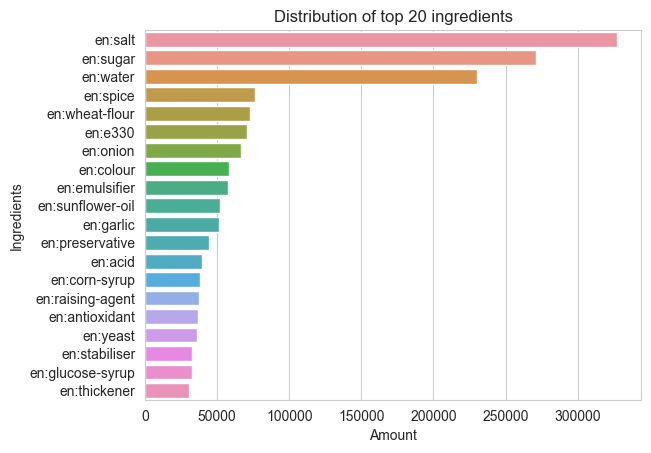

In [225]:
# plot distribution of top ten ingredients
g = sns.barplot(x=ingredients.values[:20], y=ingredients.index[:20])
_ = g.set_title('Distribution of top 20 ingredients')
_ = g.set_ylabel('Ingredients')
_ = g.set_xlabel('Amount')

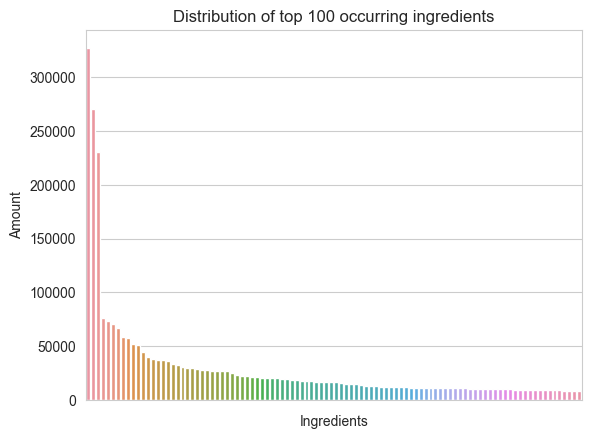

In [226]:
# plot distribution of top 100 ingredients
g = sns.barplot(x=ingredients.index[:100], y=ingredients.values[:100])
_ = g.set_title('Distribution of top 100 occurring ingredients')
_ = g.set_xticklabels([])
_ = g.set_xlabel('Ingredients')
_ = g.set_ylabel('Amount')

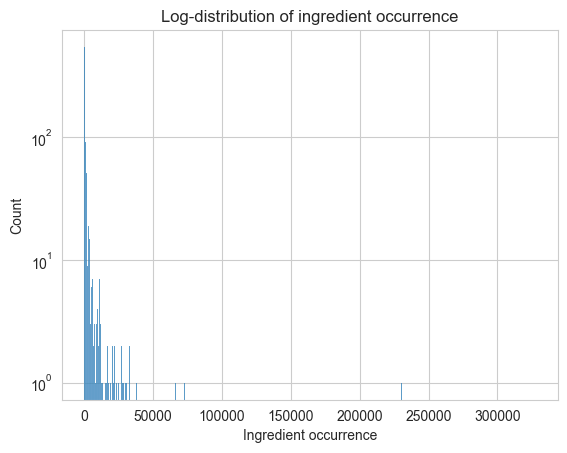

In [230]:
# plot logarithmic distribution of ingredient counts
g = sns.histplot(data=ingredients)
_ = g.set_title('Log-distribution of ingredient occurrence')
_ = g.set_xlabel('Ingredient occurrence')
_ = g.set_yscale('log')

There is a very small amount of ingredients. However, only 4 (0.3%) are used once.

In [232]:
# number of ingredients per product
products = df['product_id'].value_counts()
products.describe()

count    682042.000000
mean          5.826653
std           4.763344
min           1.000000
25%           2.000000
50%           5.000000
75%           8.000000
max         526.000000
Name: product_id, dtype: float64

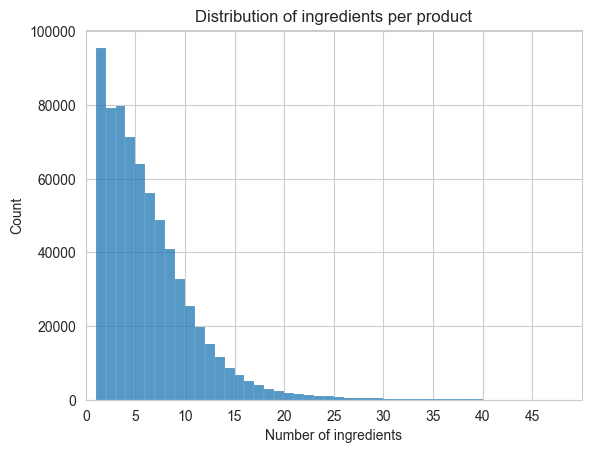

In [239]:
g = sns.histplot(products, binwidth=1)
_ = g.set_title('Distribution of ingredients per product')
_ = g.set_xlabel('Number of ingredients')
_ = g.set_xlim(0,50)
_ = g.set_xticks(range(0,50,5))

This plot shows that most of the products contain one ingredient. This is not valuable downstream, and can be removed from the dataset. 

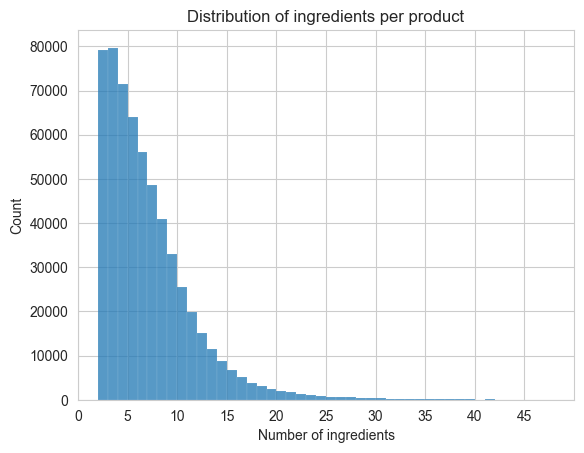

In [240]:
g = sns.histplot(products[products > 1], binwidth=1)
_ = g.set_title('Distribution of ingredients per product')
_ = g.set_xlabel('Number of ingredients')
_ = g.set_xlim(0,50)
_ = g.set_xticks(range(0,50,5))

### Attempt 2

With this approach, the nouns were extracted from the ingredients.

In [5]:
df = pd.read_csv(f'{data}/parse/.unused/parse2/relationships.csv', dtype={'ingredient_id': str, 'product_id': str})
ingredients = df['ingredient_id'].value_counts().sort_values(ascending=False)

In [6]:
print('Number of unique ingredients:', len(ingredients))
print('Number of ingredients used more than once:', len(ingredients[ingredients > 1]))

Number of unique ingredients: 37670
Number of ingredients used more than once: 37365


In [7]:
# most used ingredients
ingredients.head(15)

en:salt                  294809
en:sugar                 256770
en:water                 220133
en:natural-flavouring    101384
en:wheat-flour            69213
en:spice                  68822
en:e330                   68688
en:onion                  61134
en:flavouring             60412
en:colour                 51075
en:dextrose               49376
en:sunflower-oil          46262
en:garlic                 45963
en:emulsifier             43893
en:sea-salt               43801
Name: ingredient_id, dtype: int64

In [8]:
# least used ingredients
ingredients.tail(15)

cs:billa                                                                           1
en:citywest                                                                        1
es:de-los-cuales-azucares                                                          1
en:davon-gesattigte-fettsauren                                                     1
fr:de-gluten-et-de-fruits-a-coque                                                  1
fr:alcool-rhum-gelifie                                                             1
fr:morceaux-de-poulet-non-desosses                                                 1
fr:viande-de-boeuf-preparee-en-salaison                                            1
en:lipidos                                                                         1
fr:bien-qu-un-soin-tout-particulier-ait-ete-pris-pour-enlever-toutes-les-aretes    1
fr:puree-concentree-de-citron                                                      1
de:gatoren                                                       

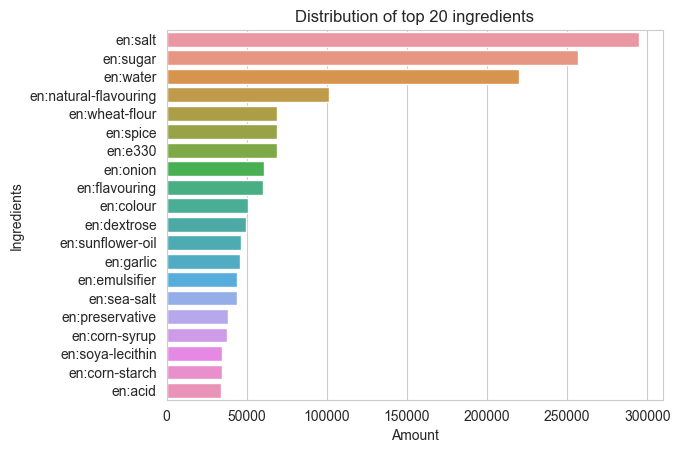

In [9]:
# plot distribution of top ten ingredients
g = sns.barplot(x=ingredients.values[:20], y=ingredients.index[:20])
_ = g.set_title('Distribution of top 20 ingredients')
_ = g.set_ylabel('Ingredients')
_ = g.set_xlabel('Amount')

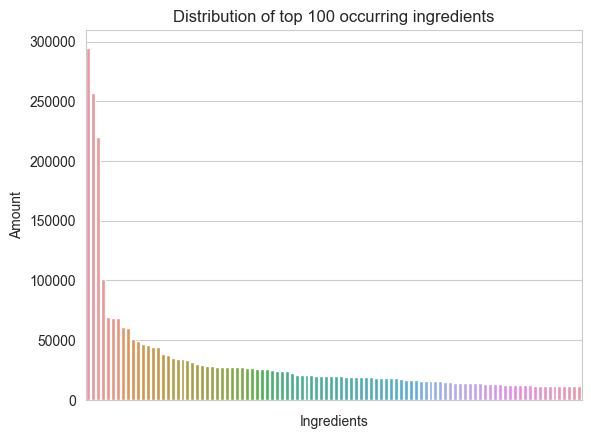

In [10]:
# plot distribution of top 100 ingredients
g = sns.barplot(x=ingredients.index[:100], y=ingredients.values[:100])
_ = g.set_title('Distribution of top 100 occurring ingredients')
_ = g.set_xticklabels([])
_ = g.set_xlabel('Ingredients')
_ = g.set_ylabel('Amount')

The amount of ingredients is a lot higher than the previous attempt. In addition, most of the ingredients are used more than once.

In [11]:
# number of ingredients per product
products = df['product_id'].value_counts()
products.describe()

count    752594.000000
mean          8.218526
std           6.889958
min           1.000000
25%           3.000000
50%           7.000000
75%          11.000000
max          99.000000
Name: product_id, dtype: float64

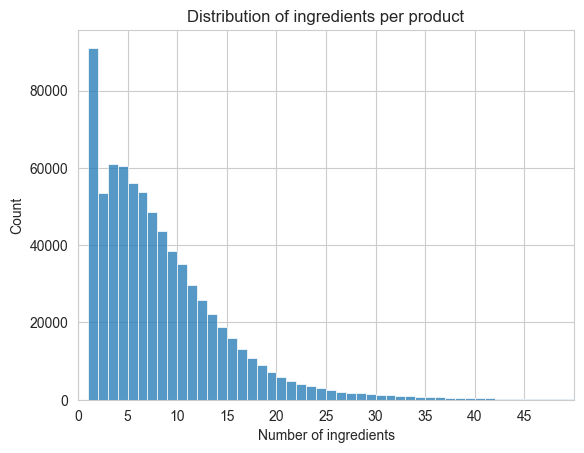

In [249]:
g = sns.histplot(products, binwidth=1)
_ = g.set_title('Distribution of ingredients per product')
_ = g.set_xlabel('Number of ingredients')
_ = g.set_xlim(0,50)
_ = g.set_xticks(range(0,50,5))

This plot shows that most of the products contain one ingredient. This is not valuable downstream, and can be removed from the dataset. 

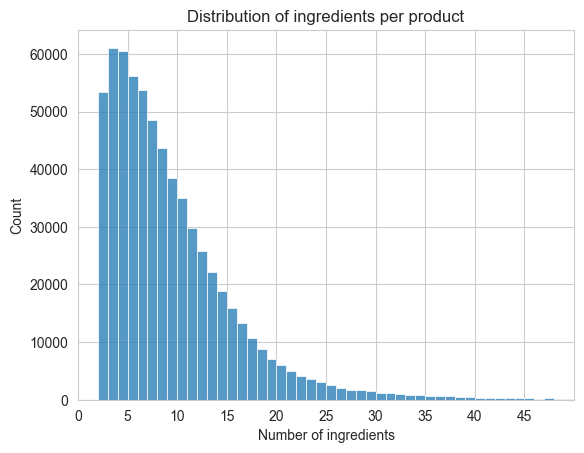

In [250]:
g = sns.histplot(products[products > 1], binwidth=1)
_ = g.set_title('Distribution of ingredients per product')
_ = g.set_xlabel('Number of ingredients')
_ = g.set_xlim(0,50)
_ = g.set_xticks(range(0,50,5))

### Attempt 3

With this approach, ingredients are matched to Wikidata URIs. Nouns are extracted from the ingredients that do not match.

In [13]:
df = pd.read_csv(f'{data}/parse/relationships.csv', dtype={'ingredient_id': str, 'product_id': str})
ingredients = df['ingredient_id'].value_counts().sort_values(ascending=False)

In [14]:
print('Number of unique ingredients:', len(ingredients))
print('Number of ingredients used more than once:', len(ingredients[ingredients > 1]))

Number of unique ingredients: 12240
Number of ingredients used more than once: 12203


In [15]:
# most used ingredients
ingredients.head(15)

salt             308674
sugar            260423
water            240876
flavouring       145081
wheat-flour       93725
spice             74631
onion             73067
e330              68677
corn-starch       62687
corn-syrup        59173
colour            53054
dextrose          51144
garlic            46768
sunflower-oil     46256
sea-salt          45659
Name: ingredient_id, dtype: int64

In [16]:
# least used ingredients
ingredients.tail(15)

lipidos                        1
mandlar                        1
sojaproteinisolat              1
ingredient-capital             1
d-omcg                         1
jujube-fruit                   1
din-care-zaharuri              1
davon-gesattigte-fettsauren    1
panna                          1
guaranteed                     1
prunus-persica                 1
suhkur                         1
mandler                        1
penrose                        1
iron-omg                       1
Name: ingredient_id, dtype: int64

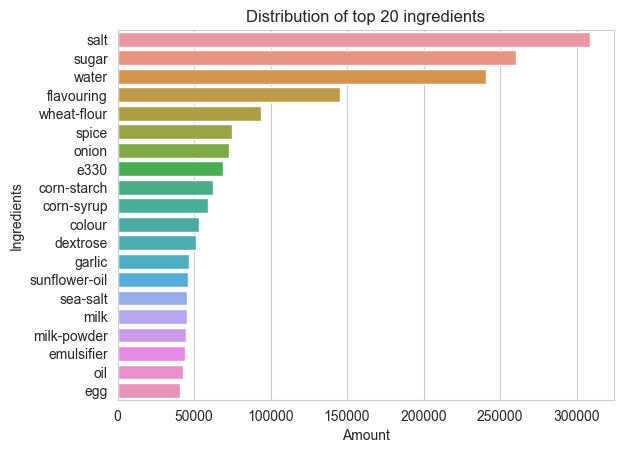

In [17]:
# plot distribution of top ten ingredients
g = sns.barplot(x=ingredients.values[:20], y=ingredients.index[:20])
_ = g.set_title('Distribution of top 20 ingredients')
_ = g.set_ylabel('Ingredients')
_ = g.set_xlabel('Amount')

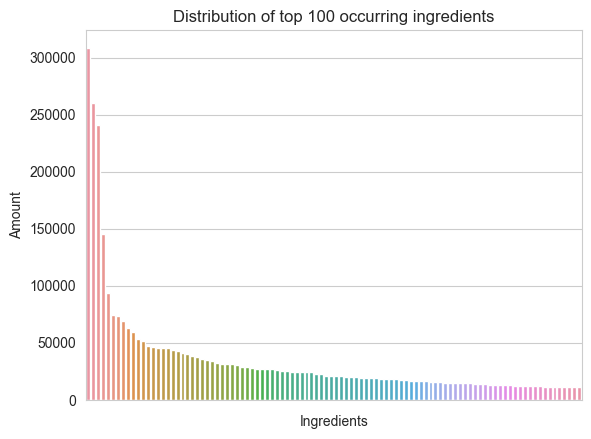

In [18]:
# plot distribution of top 100 ingredients
g = sns.barplot(x=ingredients.index[:100], y=ingredients.values[:100])
_ = g.set_title('Distribution of top 100 occurring ingredients')
_ = g.set_xticklabels([])
_ = g.set_xlabel('Ingredients')
_ = g.set_ylabel('Amount')

The amount of ingredients is a lot higher than the previous attempt. In addition, most of the ingredients are used more than once.

In [19]:
# number of ingredients per product
products = df['product_id'].value_counts()
products.describe()

count    732627.000000
mean          7.934571
std           6.702129
min           1.000000
25%           3.000000
50%           6.000000
75%          11.000000
max          66.000000
Name: product_id, dtype: float64

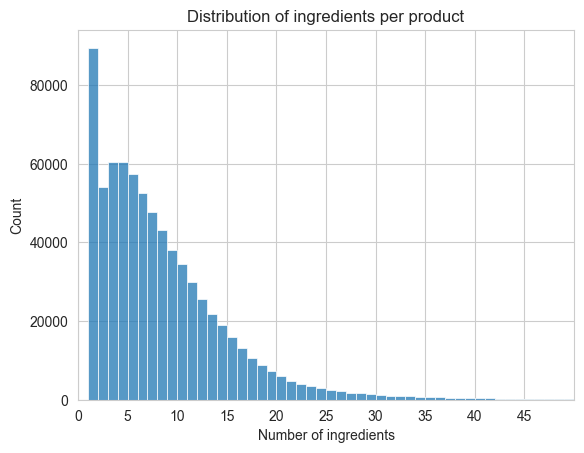

In [28]:
g = sns.histplot(products, binwidth=1)
_ = g.set_title('Distribution of ingredients per product')
_ = g.set_xlabel('Number of ingredients')
_ = g.set_xlim(0,50)
_ = g.set_xticks(range(0,50,5))

This plot shows that most of the products contain one ingredient. This is not valuable downstream, and can be removed from the dataset. 

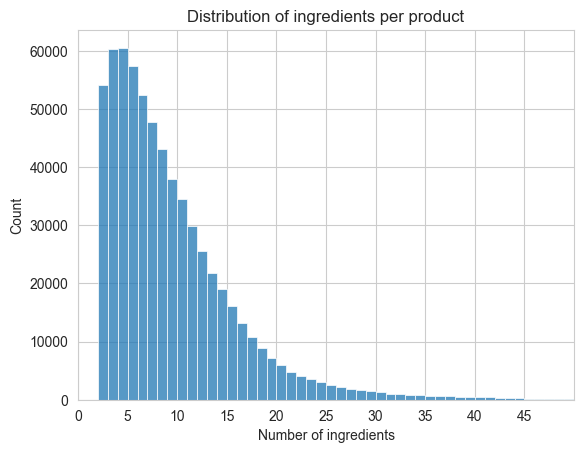

In [29]:
g = sns.histplot(products[products > 1], binwidth=1)
_ = g.set_title('Distribution of ingredients per product')
_ = g.set_xlabel('Number of ingredients')
_ = g.set_xlim(0,50)
_ = g.set_xticks(range(0,50,5))

### TF-IDF

The use of TF-IDF as a measure to clean ingredients was assessed. It did not provide good results.

In [281]:
from sklearn.feature_extraction.text import TfidfVectorizer
df = pd.read_pickle('data/dataframes/raw.pkl')

In [287]:
# set threshold for ingredients to keep
thr = 0.5

# prepare ingredient-documents for TF-IDF
df = df.groupby('product name', as_index=False).agg({'ingredient': lambda x: ' '.join(x.tolist())})
ingredients = df['ingredient'].tolist()

# calculate TF-IDF
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(ingredients)
feature_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
denselist = dense.tolist()
tf = pd.DataFrame(denselist, columns=feature_names).T
tf['score'] = tf.max(axis=1)

In [286]:
# ingredients to keep
tf.index[tf['score'] > thr]

Index(['adzuki', 'almond', 'apricot', 'arborio', 'banana', 'barley', 'basmati',
       'beans', 'bran', 'bulgur', 'carrot', 'cashew', 'chickpea', 'cinnamon',
       'coconut', 'currants', 'e220', 'flakes', 'fr', 'groats', 'hazelnut',
       'hulless', 'ingredients', 'jasmine', 'khorasan', 'lentils', 'maple',
       'mascobado', 'medjool', 'millet', 'mung', 'nourishment', 'org',
       'peanut', 'pearl', 'pearled', 'pistachio', 'plum', 'polenta', 'popcorn',
       'pumpkin', 'quinoa', 'rye', 'sesame', 'sunflower', 'sushi', 'sweet',
       'walnut', 'water', 'wheat', 'wild', 'zante'],
      dtype='object')

## Graph data

After the data is preprocessed and imported to the graph, it can be read back into memory. Talk about how Wikidata is used to clean up ingredient names.

In [21]:
G = Graph('neo4j://localhost:7687', auth=('neo4j', 'admin'))

In [36]:
# number of products in the graph
query = r"""MATCH(p:Product) RETURN COUNT(p) as products"""
print(G.query(query))
# number of ingredients in the graph
query = r"""MATCH(i:Ingredient) RETURN COUNT(i) as ingredients"""
print(G.query(query))
# number of product-ingredient relationships
query = r"""MATCH(:Ingredient)-[r:INGREDIENT_IN]->(:Product) RETURN COUNT(r) as ing2prod"""
print(G.query(query))
# number of items from wikidata
query = r"""MATCH(n:Class) RETURN COUNT(n) as wikidata"""
print(G.query(query))
# number of ingredients that match wikidata
query = r"""MATCH(n:Ingredient:Class) RETURN COUNT(n) as wikimatches"""
print(G.query(query))
# number of ingredient-class relationships
query = r"""MATCH(:Ingredient)-[r:SUBCLASS_OF|INSTANCE_OF]->(:Class) RETURN COUNT(r) as ing2class"""
print(G.query(query))
# number of product co-occurrence relationships
query = r"""MATCH(:Ingredient)-[r:CO_PRODUCT|CO_CLASS]->(:Ingredient) RETURN COUNT(r) AS cooccurrence"""
print(G.query(query))

 products 
----------
   704514 

 ingredients 
-------------
       12253 

 ing2prod 
----------
  5713624 

 wikidata 
----------
    22346 

 wikimatches 
-------------
         700 

 ing2class 
-----------
      1264 

 cooccurrence 
--------------
      1181467 



In [ ]:
# get occurrence of ingredients
query = r"""
MATCH(i:Ingredient)-[r:INGREDIENT_IN]->()
OPTIONAL MATCH(i)-[r1:SUBCLASS_OF]-()
OPTIONAL MATCH(i)-[r2:INSTANCE_OF]-()
RETURN i.name as ingredient, COUNT(DISTINCT r) AS INGREDIENT_IN, COUNT(DISTINCT r1) AS SUBCLASS_OF, COUNT(DISTINCT r2) AS INSTANCE_OF
"""
ingredients = G.query(query).to_data_frame()

In [27]:
print('Number of unique ingredients:',len(ingredients['ingredient']))

Number of unique ingredients: 12160


In [28]:
# get distribution of degrees
ingredients['degree'] = ingredients[['INGREDIENT_IN', 'SUBCLASS_OF', 'INSTANCE_OF']].apply(lambda x: sum(x), axis=1)
# sort by degree
ingredients = ingredients.sort_values(by='degree', ascending=False) 
# get stats
ingredients['degree'].describe()

count     12160.000000
mean        470.395066
std        5247.494303
min           1.000000
25%           6.000000
50%          12.000000
75%          40.000000
max      307090.000000
Name: degree, dtype: float64

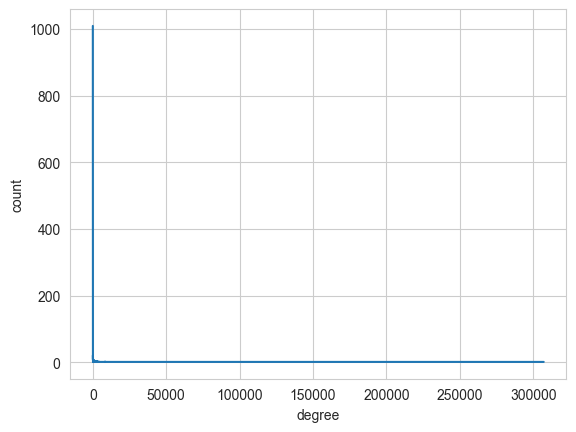

In [144]:
# plot distribution
dist = ingredients['degree'].value_counts().rename_axis('degree').reset_index(name='count').sort_values(by='degree', ascending=True)
g = sns.lineplot(x='degree', y='count', data=dist)

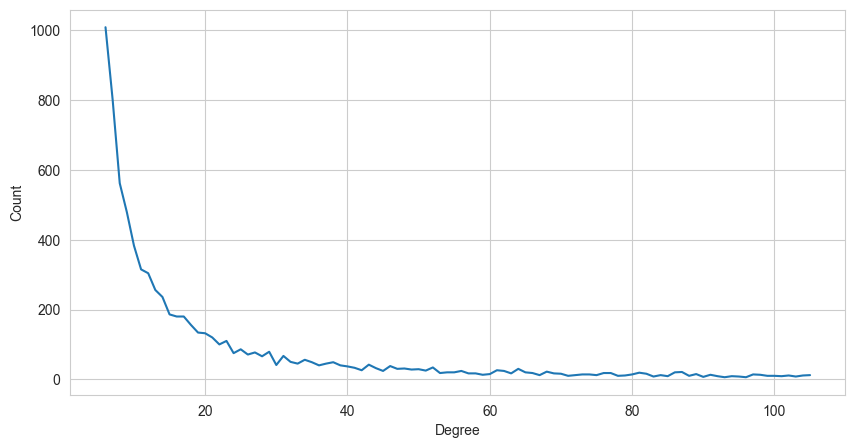

In [145]:
# get distribution of occurrences
plt.figure(figsize=(10,5))
g = sns.lineplot(x='degree', y='count', data=dist[:100], )
_ = g.set_xlabel('Degree')
_ = g.set_ylabel('Count')
plt.savefig(data+'/results/neo/ingocc_neo.png', dpi=300)

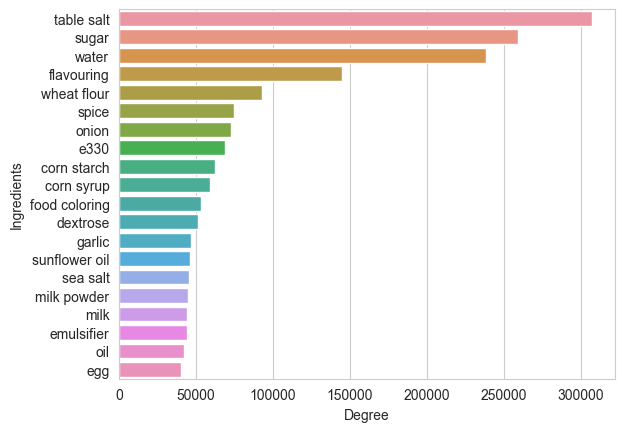

In [148]:
# plot distribution of top 20 ingredients
g = sns.barplot(data=ingredients[:20], x='degree', y='ingredient')
_ = g.set_ylabel('Ingredients')
_ = g.set_xlabel('Degree')
plt.savefig(data+'/results/neo/top20neo.png', bbox_inches='tight', dpi=300)

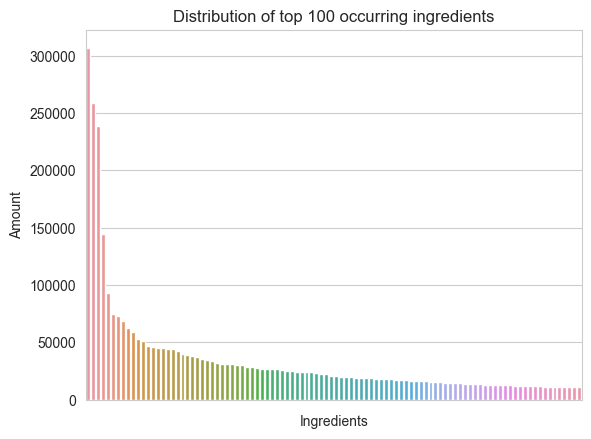

In [331]:
# plot distribution of top 100 ingredients
g = sns.barplot(data=ingredients[:100], x='ingredient', y='count')
_ = g.set_title('Distribution of top 100 occurring ingredients')
_ = g.set_xticklabels([])
_ = g.set_xlabel('Ingredients')
_ = g.set_ylabel('Amount')

In [341]:
ingredients.head(20)

,ingredient,count
0,table salt,307075
1,sugar,258940
2,water,238623
3,flavouring,144931
4,wheat flour,93028
5,spice,74549
6,onion,72810
7,e330,68507
8,corn starch,62492
9,corn syrup,59156


In [346]:
ingredients.tail(50)

,ingredient,count
9591,leaf-wax,6
9592,palm-vegetable-oil-oil,6
9593,radish-seed,6
9594,wheat-flour-topping,6
9595,vinegar-aceto-balsamico-modena-i-p,6
9596,sunflo,6
9597,conta,6
9598,cell,6
9599,northfield,6
9600,moisture-part-skim-mozzarella-cheese,6


In [344]:
# print latex table of lowest occurring ingredients
for ingredient in ingredients['ingredient'][ingredients['count'] == 6]:
    print(
f"""{ingredient} \\\\"""
    )

dough-strengthener \\
sodium-monostearate \\
digylcerides \\
lnulin \\
ga-member-coca-cola-bottler-association \\
jack-mackerel \\
food-preservative \\
canesugar \\
stone-ground-grain-cornmeal \\
gm-expeller-oil \\
calcium-lactate-beet \\
crunch-blend \\
oni \\
chicken-breast-fillet-strip-rib-meat \\
graham-cracker-crust \\
fat-soy-flour \\
pork-cracklins \\
turbos \\
yello \\
lime-bean \\
salt-water \\
cornish-cream \\
raspberry-preparation \\
xathan-gum \\
ingredient-mozzarella-cheese \\
cherry-flavor-flavor \\
crispy-noodle \\
champagne-flavor \\
ni \\
grade \\
beef-bite \\
ginger-wonton-strip \\
onion-dijon \\
pinenuts \\
raspberry-cranberry \\
pork-carnitas \\
apple-juice-corn-syrup \\
gf-flax-meal \\
xanthan-gu \\
calcium-panthothenate \\
baby-oak-leaf \\
star \\
grana-cheese \\
salt-calcium-chloride \\
soda-salt \\
milk-flavour-coating \\
fruit-center-fruit-puree \\
yogurt-coating-sugar \\
tapioca-strach \\
rainbow-nonpareil \\
sulfites-color-retention \\
glucono \\
dark-meat \\

In [22]:
# get degrees of product nodes
query = r"""
MATCH(p:Product)<-[r:INGREDIENT_IN]-(i:Ingredient)
RETURN p.name AS product, p.barcode AS barcode, COUNT(DISTINCT(i)) AS n_ingredients
"""
products = G.query(query).to_data_frame()

# remove products with one ingredient
products = products[products['n_ingredients'] > 1]

In [23]:
products['n_ingredients'].describe()

count    642449.000000
mean          8.652055
std           6.123922
min           2.000000
25%           4.000000
50%           7.000000
75%          11.000000
max          57.000000
Name: n_ingredients, dtype: float64

In [24]:
# get distribution of the number of ingredients per product
products['n_ingredients'].value_counts()

4     61833
3     61224
5     58594
2     54600
6     53513
7     48401
8     43998
9     39012
10    34884
11    29835
12    25973
13    22458
14    18690
15    15410
16    12794
17    10250
18     8303
19     6533
20     5458
21     4556
22     3889
23     3292
24     2562
25     2141
26     1840
27     1714
28     1535
29     1309
30     1066
31      874
32      785
33      665
34      612
35      541
36      476
37      433
38      383
40      350
39      317
41      236
42      192
44      190
45      135
43      130
46       99
47       97
49       65
50       59
48       56
51       45
52       25
53       10
56        3
55        2
57        1
54        1
Name: n_ingredients, dtype: int64

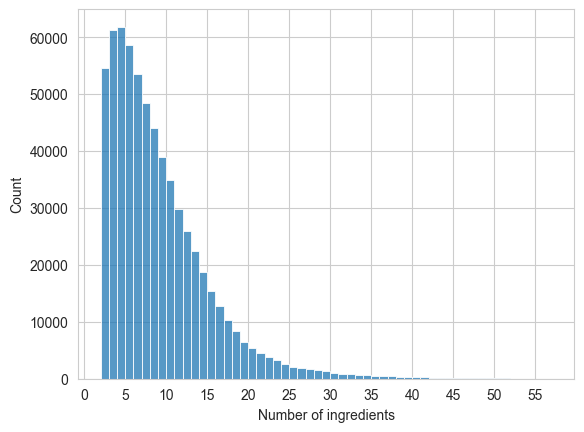

In [25]:
g = sns.histplot(products, x='n_ingredients', binwidth=1)
_ = g.set_xticks(range(0,57, 5))
_ = g.set_xlabel('Number of ingredients')
plt.savefig(data+'/results/neo/ingperprod_neo.png', dpi=300)

Most products contain three to four ingredients.

In [38]:
# get names of top 100 ingredients based on degree
top = set(ingredients['ingredient'][:100])

In [ ]:
# query neo and get co-occurrence matrix based on product occurrence
query = r"""
MATCH (i1:Ingredient)-[r:CO_PRODUCT]-(i2:Ingredient)
WITH i1.name AS ing1, r.amount AS occurrence, i2.name AS ing2
RETURN ing1, ing2, occurrence;
"""
prod_cooc = G.run(query).to_data_frame()

# sort values based on occurrence
prod_cooc = prod_cooc.sort_values(by='occurrence', ascending=False)

# dump to pickle
prod_cooc.to_pickle(data+'/dataframes/prod_cooc.pkl')

In [14]:
prod_cooc = pd.read_pickle(data+'/dataframes/prod_cooc.pkl')

In [20]:
prod_cooc['ing1'].value_counts()

table salt              8565
water                   8517
sugar                   8291
corn starch             5893
oil                     5557
                        ... 
porce                      1
handmade-rice-koji         1
non-gmo-plant-pectin       1
coconut-flesh-pulp         1
penrose                    1
Name: ing1, Length: 12107, dtype: int64

In [28]:
prod_cooc.sort_values(by='occurrence')

,ing1,ing2,occurrence
1070348,wheat,color-sprinkle,1
353324,barley,tea-extract,1
353329,e508,tea-extract,1
353331,wate,tea-extract,1
353333,oats,tea-extract,1
...,...,...,...
484551,coagulant,ferment,899
484576,goat milk,ferment,1040
484647,rennet,ferment,1065
1133580,sardines as food,table salt,1106


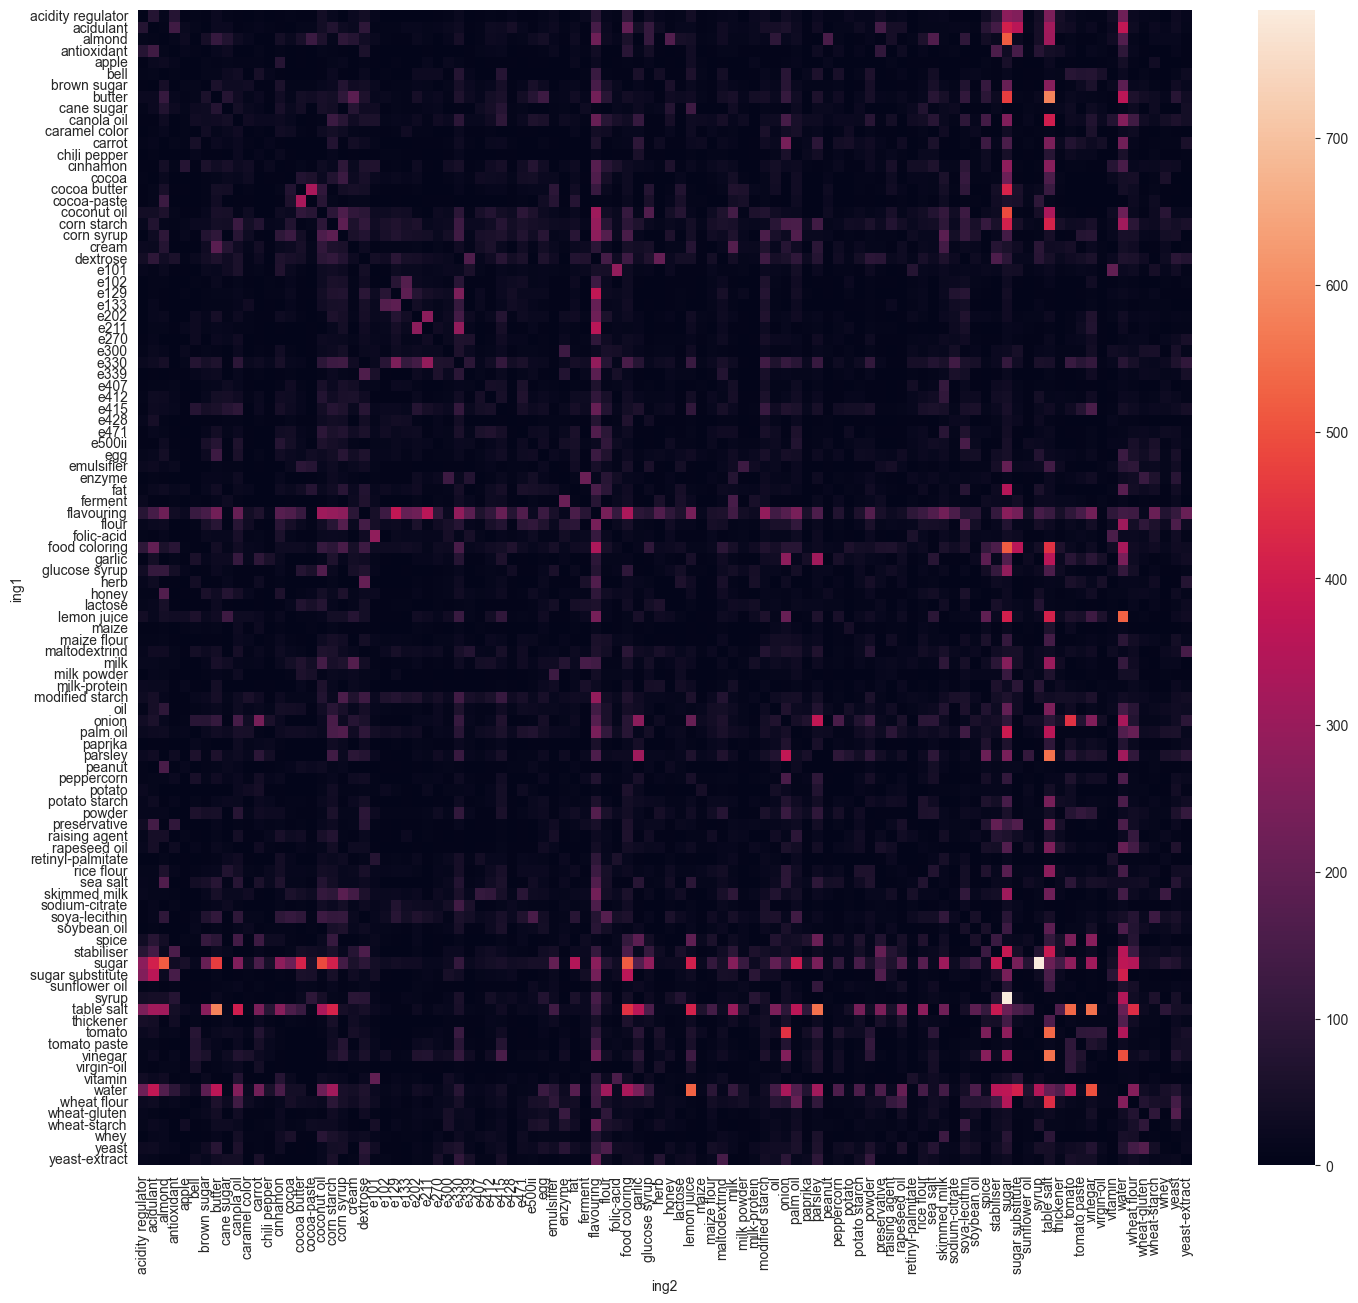

In [102]:
'''Product co-occurrence heatmap of 100 most common ingredients.'''
# read ingredient co-occurrence based on products
prod_cooc = pd.read_pickle(data+'/dataframes/prod_cooc.pkl')
# convert all ingredient names to lowercase
prod_cooc = prod_cooc.applymap(lambda s: s.lower() if type(s) == str else s)

# select 100 most common ingredients
prod_cooc = prod_cooc.loc[prod_cooc['ing1'].isin(top)]
prod_cooc = prod_cooc.loc[prod_cooc['ing2'].isin(top)]

# get both directions of relationship
rev_cooc = prod_cooc[['ing2', 'ing1', 'occurrence']]
rev_cooc.columns = ['ing1', 'ing2', 'occurrence']
prod_cooc = pd.concat((prod_cooc, rev_cooc))

# create pivot table
prod_pivot = prod_cooc.pivot_table(index='ing1', columns='ing2', values='occurrence', fill_value=0)

# plot heatmap
ax = plt.figure(figsize=(17,15))
sns.heatmap(prod_pivot, xticklabels=True, yticklabels=True)
plt.savefig(data+'/results/neo/product_heatmap.png', dpi=300)

In [36]:
df = pd.read_pickle('../data/dataframes/all.pkl')

In [53]:
l = ['mayo', 'man', 'halo', 'table salt', 'goat milk']


True

## Dairy
Because of the enrichment, it is now possible to select ingredients of certain categories. Below, an example with dairy ingredients is shown.

In [40]:
query = r"""
MATCH(c:Class)
WHERE c.name = 'dairy product'
MATCH(c)<-[:SUBCLASS_OF*]-(i:Ingredient)
MATCH(i)-[r:INGREDIENT_IN]->(p:Product)
RETURN i.name as ingredient, COUNT(r) AS count"""
dairy = G.query(query).to_data_frame()
dairy = dairy.sort_values(by='count', ascending=False)

In [41]:
print(f'{len(dairy)} ingredients are connected to the dairy class')

60 ingredients are connected to the dairy class


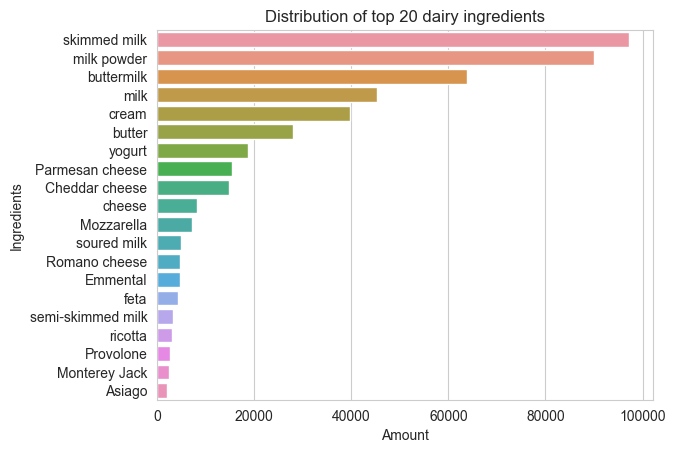

In [42]:
# plot distribution of top 20 dairy ingredients
g = sns.barplot(data=dairy[:20], x='count', y='ingredient')
_ = g.set_title('Distribution of top 20 dairy ingredients')
_ = g.set_ylabel('Ingredients')
_ = g.set_xlabel('Amount')

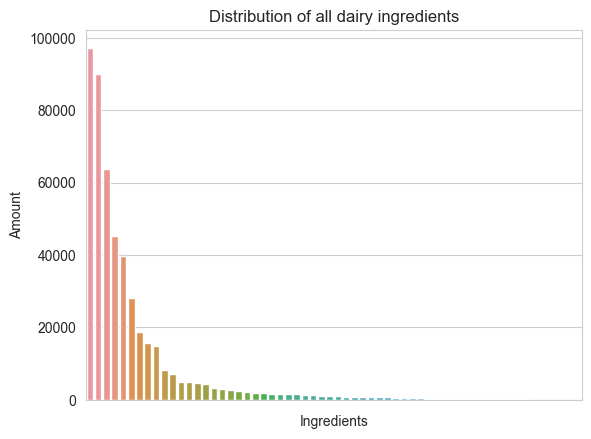

In [43]:
# plot distribution of all dairy ingredients
g = sns.barplot(data=dairy, x='ingredient', y='count')
_ = g.set_title('Distribution of all dairy ingredients')
_ = g.set_xticklabels([])
_ = g.set_xlabel('Ingredients')
_ = g.set_ylabel('Amount')

In [44]:
# get number of ingredients for dairy products
query = r"""
MATCH(c:Class {name: 'dairy product'})
MATCH(c)<-[:SUBCLASS_OF*]-(:Ingredient)-[:INGREDIENT_IN]->(p:Product)
WITH DISTINCT(p) AS p
MATCH (i:Ingredient)-[:INGREDIENT_IN]->(p)
RETURN p.name AS product, p.barcode AS barcode, COUNT(i) AS ingredients;
"""
dairy = G.query(query).to_data_frame()

In [45]:
dairy['ingredients'].describe()

count    161030.000000
mean         11.338589
std           8.351595
min           1.000000
25%           5.000000
50%           9.000000
75%          15.000000
max          66.000000
Name: ingredients, dtype: float64

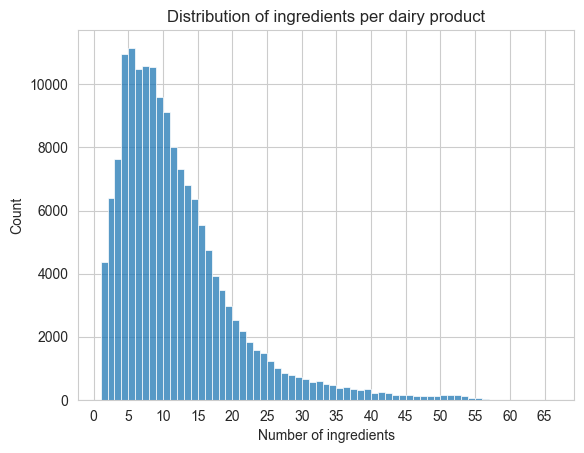

In [46]:
# plot number of ingredients per dairy product
g = sns.histplot(dairy, x='ingredients', binwidth=1)
_ = g.set_title('Distribution of ingredients per dairy product')
_ = g.set_xticks(range(0,66, 5))
_ = g.set_xlabel('Number of ingredients')

Dairy products usually contain around five ingredients.